In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons

%matplotlib notebook

In [31]:
# Define material parameters:
rho = 0.91          # Density of Er ions (*1E21 cm^-3)
tau = 10            # Radiative decay rate
d = 1E-4*1          # Thickness of slab (cm)
sigma_12 = 4.1      # Absorption cross-section (*1E-21 cm^2)
sigma_21 = 5        # Emission cross-section (*1E-21 cm^2)
n = 1               # Total number of active ions (i.e.,clustering)

# Lambert and ODEINT

In [48]:
# Lambert W solution
def lamb(t, n1_0, r, multiplier=1):
    alpha = (1+r/2)*rho*d*multiplier
    A = alpha*(sigma_12+sigma_21)
    B = 1 + alpha*sigma_12*n
    arg = -A*n1_0*exp(-(t/(B*tau))-(A*n1_0)/B)/B
    # Check that result is real
    assert min(arg) >= -1/e, \
        'Lambert W Argument will give an imaginary result.'
    return -B*lambertw(arg).real/A

# solve the system dy/dt = f(y, t) numerically
def f(y, t, r, multiplier=1):
    n1 = y[0]
    a = (1+r/2)*rho*d*multiplier
    dn1dt = - n1 / (tau*(1+a*n*sigma_12-a*n1*(sigma_12+sigma_21)))
    return [dn1dt]

<IPython.core.display.Javascript object>


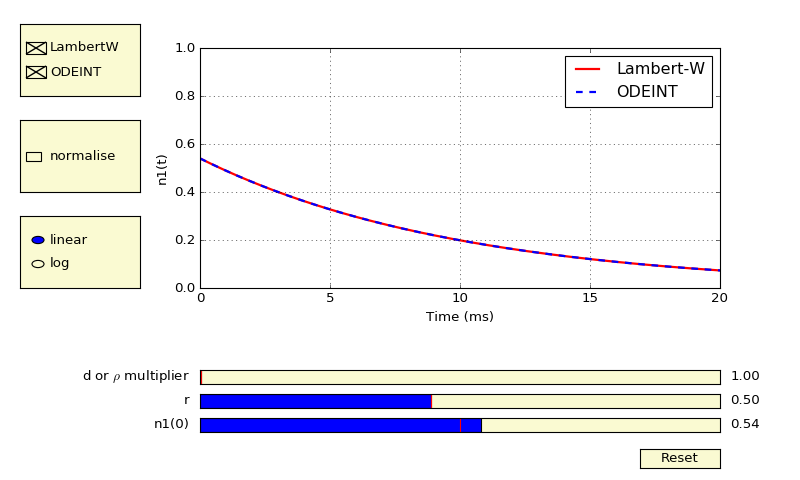

0

In [68]:
# Setup figure
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(left=0.25, bottom=0.4)
ax = plt.subplot(111)
plt.axis([0, 20, 0, 1])
plt.xlabel('Time (ms)')
plt.ylabel('n1(t)')
plt.grid()

# Initial conditions
n1_0 = 0.5           # Starting population excitation
r = 0.5
t  = np.linspace(0, 100, 1000)   # time grid

# solve the decay function
n1a = lamb(t, n1_0, r)
n1b = odeint(f, [n1_0], t, args=(r,))[:, 0]
la, = plt.plot(t, n1a, lw=2, color='red', label='Lambert-W')
lb, = plt.plot(t, n1b, lw=2, ls='--', color='blue', label='ODEINT')
plt.legend()

# Sliders
axcolor = 'lightgoldenrodyellow'
axn1 = plt.axes([0.25, 0.1, 0.65, 0.03], axisbg=axcolor)
axr = plt.axes([0.25, 0.15, 0.65, 0.03], axisbg=axcolor)
axxd = plt.axes([0.25, 0.2, 0.65, 0.03], axisbg=axcolor)

sn1 = Slider(axn1, 'n1(0)', 0, 1.0, valinit=n1_0)
sr = Slider(axr, 'r', 0.1, 1.0, valinit=r)
sxd = Slider(axxd, r'd or $\rho$ multiplier', 0, 1000, valinit=1)

norm = False
def update(val):       
    n1_0 = sn1.val
    r = sr.val
    multiplier = sxd.val
    # re-solve the decay functions with new values
    n1a = lamb(t, n1_0, r, multiplier)
    n1b = odeint(f, [n1_0], t, args=(r,multiplier))[:, 0]

    # Normalise decay
    if norm:
        n1a /= np.max(n1a)
        n1b /= np.max(n1b)

    la.set_ydata(n1a)
    lb.set_ydata(n1b)
    plt.draw()
sn1.on_changed(update)
sr.on_changed(update)
sxd.on_changed(update)

# Show only certain solutions
rax = plt.axes([0.025, 0.8, 0.15, 0.15], axisbg=axcolor)
check = CheckButtons(rax, ('LambertW', 'ODEINT'), (True, True))
def func(label):
    if label == 'LambertW':
        la.set_visible(not la.get_visible())
    elif label == 'ODEINT':
        lb.set_visible(not lb.get_visible())
    plt.draw()
check.on_clicked(func)

# Normalise data
rax = plt.axes([0.025, 0.6, 0.15, 0.15], axisbg=axcolor)
check2 = CheckButtons(rax, ('normalise',), (False,))
def checkbox(label):
    if label == 'normalise':
        global norm
        norm = not norm    
check2.on_clicked(checkbox)
check2.on_clicked(update)

# Scale log or linear for y axis
rax = plt.axes([0.025, 0.4, 0.15, 0.15], axisbg=axcolor)
radio2 = RadioButtons(rax, ('linear', 'log'))
def scale(label):
    ax.set_yscale(label)
    if label == 'log':
        ax.set_ylim(0.01, 1)
    else:
        ax.set_ylim(0, 1)
    plt.draw()
radio2.on_clicked(scale)

# Reset button
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
def reset(event):
    sn1.reset()
    sr.reset()
    sxd.reset()
button.on_clicked(reset)

# Lambert W

In [41]:
from scipy.special import lambertw
from numpy import exp, e

def lamb(t, n1_0, r, multiplier):

    alpha = (1+r/2)*rho*d*multiplier
    A = alpha*(sigma_12+sigma_21)
    B = 1 + alpha*sigma_12*n

    arg = -A*n1_0*exp(-(t/(B*tau))-(A*n1_0)/B)/B

    # Check that result is real
    assert min(arg) >= -1/e, \
        'Lambert W Argument will give an imaginary result.'

    return -B*lambertw(arg).real/A

<IPython.core.display.Javascript object>


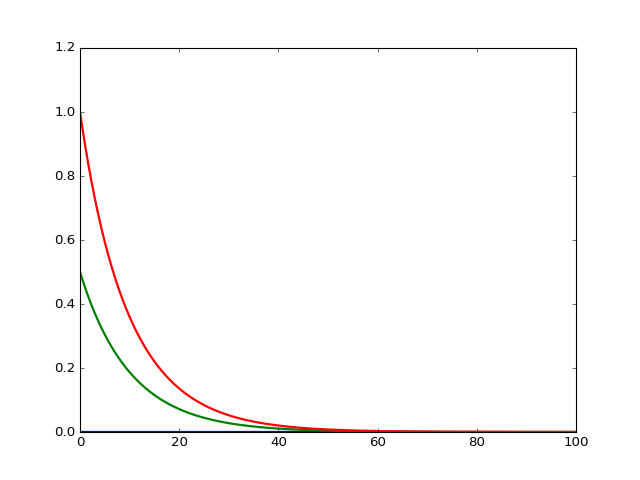

In [42]:
# Time to simulate over
t = np.linspace(0, 100, 1000)

r = 1         # Reflectivity of top layer
n1_0 = 0.8     # Number of excited ions at t=0
multiplier = 100

plt.figure()
for n1_0 in [0, 0.5, 1]:
    plt.plot(t, lamb(t, n1_0, r, multiplier), ls='-', lw=2)

Animate? - see: http://www.danham.me/r/2015/10/29/differential-eq.html

# Odeint version

In [50]:
from scipy.integrate import odeint

In [46]:
# solve the system dy/dt = f(y, t)
def f(y, t, r, multiplier=1):
    n1 = y[0]
    a = (1+r/2)*rho*d*multiplier
    dn1dt = - n1 / (tau*(1+a*n*sigma_12-a*n1*(sigma_12+sigma_21)))
    return [dn1dt]

<IPython.core.display.Javascript object>


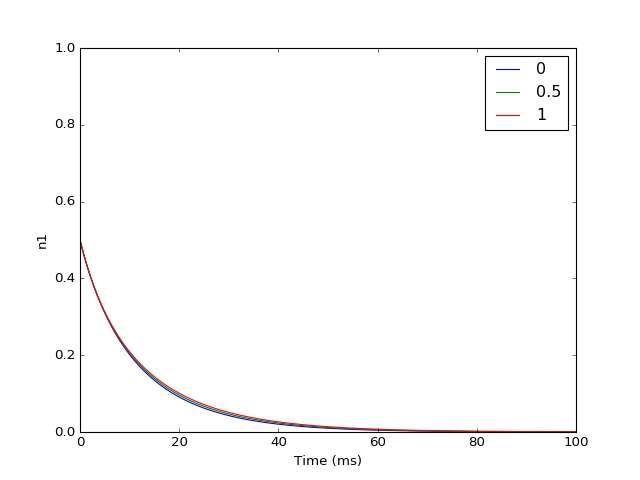

In [117]:
# Solve for multiple values of r
t  = np.linspace(0, 100, 1000)   # time grid
multiplier = 1000

plt.figure()
for r in [0, 0.5, 1]:
    y0 = [n1_0]

    # solve the DEs
    soln = odeint(f, y0, t, args=(r, multiplier))
    n1 = soln[:, 0]

    plt.plot(t, n1, label=str(r))

plt.axis([0, 100, 0, 1])
plt.xlabel('Time (ms)')
plt.ylabel('n1')
plt.legend(loc=0)

see: http://scipy.github.io/old-wiki/pages/Cookbook/Zombie_Apocalypse_ODEINT for coupled example.

# ODE Version

In [118]:
from scipy.integrate import ode

In [132]:
# solve the system dy/dt = f(t, y)
def f(t, y, r, multiplier=1):
    n1 = y
    a = (1+r/2)*rho*d*multiplier
    dn1dt = - n1 / (tau*(1+a*n*sigma_12-a*n1*(sigma_12+sigma_21)))
    return [dn1dt]

<IPython.core.display.Javascript object>


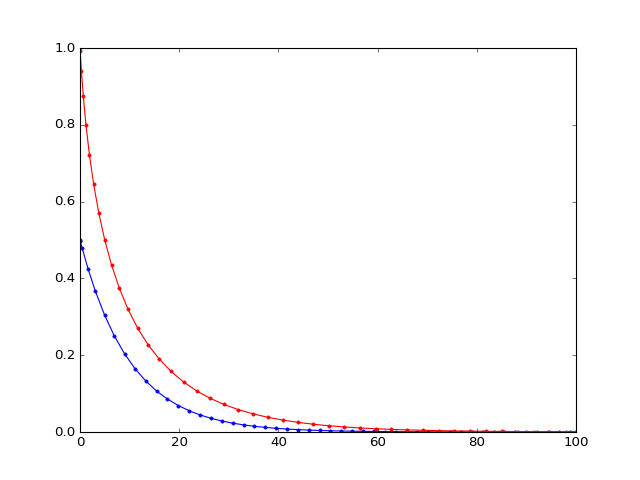

In [168]:
y0 = [0.5]
t0 = 0
t1 = 100

r = 0.5

# Array to save results to
def solout(t, y):
    sol.append([t, *y])

solver = ode(f).set_integrator('dopri5')
solver.set_solout(solout)
solver.set_initial_value(y0, t0)
solver.set_f_params(r)

sol = []
solver.integrate(t1)
sol = np.array(sol)

plt.figure()
plt.plot(sol[:,0], sol[:,1], 'b.-')

multiplier = 1000
y0 = [1]
solver.set_initial_value(y0, t0).set_f_params(r, multiplier)
sol = []
solver.integrate(t1)
sol = np.array(sol)
plt.plot(sol[:,0], sol[:,1], 'r.-')

<IPython.core.display.Javascript object>


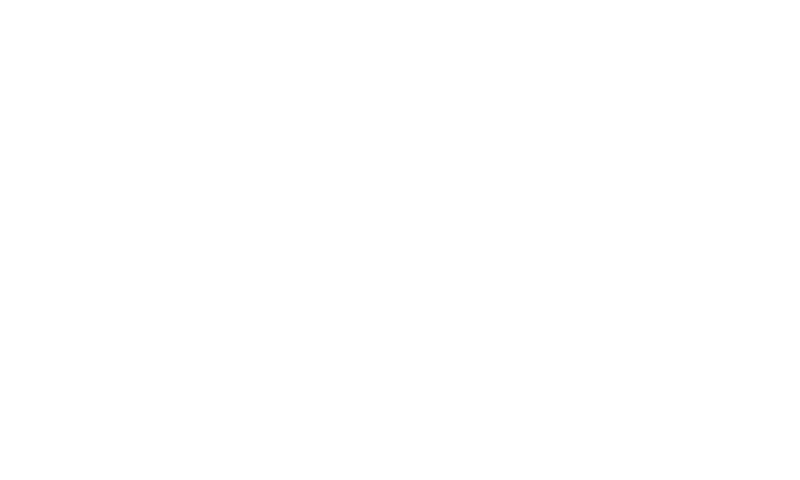

0

In [175]:
# Array to save results to
def solout(t, y):
    sol.append([t, *y])

# Initial conditions
n1_0 = 0.5           # Starting population excitation
y0 = [n1_0]          # initial condition vector

# solve the DEs
t0 = 0
t1 = 100
r = 0.5
    
solver = ode(f).set_integrator('dopri5')
solver.set_solout(solout)
solver.set_initial_value(y0, t0).set_f_params(r)

fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(left=0.25, bottom=0.4)
ax = plt.subplot(111)

sol = []
solver.integrate(t1)
sol = np.array(sol)
t = sol[:, 0]
n1 = sol[:, 1]

l, = plt.plot(t, n1, lw=2, color='red')
plt.axis([0, 20, 0, 1])
plt.xlabel('Time (ms)')
plt.ylabel('n1(t)')
plt.grid()

axcolor = 'lightgoldenrodyellow'
axn1 = plt.axes([0.25, 0.1, 0.65, 0.03], axisbg=axcolor)
axr = plt.axes([0.25, 0.15, 0.65, 0.03], axisbg=axcolor)
axxd = plt.axes([0.25, 0.2, 0.65, 0.03], axisbg=axcolor)

sn1 = Slider(axn1, 'n1(0)', 0, 1.0, valinit=n1_0)
sr = Slider(axr, 'r', 0.1, 1.0, valinit=r)
sxd = Slider(axxd, r'd or $\rho$ multiplier', 0, 1000, valinit=1)

global norm 
norm = False

def update(val):       
    n1_0 = sn1.val
    y0 = [n1_0]
    multiplier = sxd.val
    r = sr.val
    # Array to save results to
    def solout(t, y):
        sol.append([t, *y])
    solver = ode(f).set_integrator('dopri5')
    solver.set_solout(solout)
    solver.set_initial_value(y0, t0).set_f_params(r, multiplier)
    sol = []
    solver.integrate(t1)
    sol = np.array(sol)
    t = sol[:, 0]
    n1 = sol[:, 1]

    # Normalise decay
    if norm:
        n1 /= np.max(n1)
    
    l.set_ydata(n1)
    plt.draw()

sn1.on_changed(update)
sr.on_changed(update)
sxd.on_changed(update)

rax = plt.axes([0.025, 0.6, 0.15, 0.15], axisbg=axcolor)
check = CheckButtons(rax, ('normalise',), (False,))

def checkbox(label):
    if label == 'normalise':
        global norm
        norm = not norm        
check.on_clicked(checkbox)
check.on_clicked(update)

rax = plt.axes([0.025, 0.4, 0.15, 0.15], axisbg=axcolor)
radio2 = RadioButtons(rax, ('linear', 'log'))
def scale(label):
    ax.set_yscale(label)
    if label == 'log':
        ax.set_ylim(0.01, 1)
    else:
        ax.set_ylim(0, 1)
    plt.draw()
radio2.on_clicked(scale)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
def reset(event):
    sn1.reset()
    sr.reset()
    sxd.reset()
    check.active = False
button.on_clicked(reset)

http://stackoverflow.com/questions/12926393/using-adaptive-step-sizes-with-scipy-integrate-ode

# Misc

http://www.danham.me/r/2015/10/29/differential-eq.html

http://ipython-books.github.io/featured-05/

http://jakevdp.github.io/blog/2012/09/05/quantum-python/


In [146]:
plt.close('all')